# MLP-12 For Digit Recognition on MNIST

**Architecture: 784-FC:12-10**

Here, 
- FC: Fully connected layer with ReLU activation

**Naming Conventions**
- Small letter variables are local to a section
- Capitalized variables are used across sections
- Functions are always assumed to be used across sections

# Environment Setup

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading Dataset

Dataset will be downloaded using PyTorch into a local directory.

In [2]:
data_path = "./dataset"

Train_dataset = datasets.MNIST(data_path, 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

Test_dataset = datasets.MNIST(data_path, 
                                    train=False, 
                                    transform=transforms.ToTensor())

# Explore Dataset to Understand

Note: 
- MNIST data items are a tuple of image and a label. 
- The image is a tensor of dimension (1, 28, 28). The first axis if probably for the image channel. As it is a grayscale image, there is only one channel.
- The label is a number corresponding to the image.

In [3]:
# Check out an item
item = Train_dataset[0]
print('item:', type(item), '  len:', len(item))
print('item[0]:', type(item[0]), '  item[1]:', type(item[1]))
print('item[0]:', item[0].size())

img = item[0].flatten()
print('')
print('min:', torch.min(img))
print('max:', torch.max(img))
print('avg:', torch.mean(img))

item: <class 'tuple'>   len: 2
item[0]: <class 'torch.Tensor'>   item[1]: <class 'int'>
item[0]: torch.Size([1, 28, 28])

min: tensor(0.)
max: tensor(1.)
avg: tensor(0.1377)


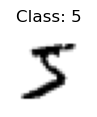

In [4]:
# Show an example data item
def showItem(item, newfig=True):
    if newfig: plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(item[0].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f'Class: {item[1]}')

    
showItem(item, newfig=True)

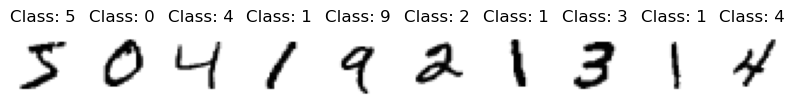

In [5]:
# Show a few more items
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    item = Train_dataset[i]
    plt.subplot(1,10,i+1)
    showItem(item, newfig=False)

# Trim Down Dataset

If needed, trim down the dataset here for faster experimentation

In [6]:
print('Train:', len(Train_dataset))
print('Test :', len(Test_dataset))

Train: 60000
Test : 10000


# Define Features and Labels

The features for this MLP12 model are selected to be the raw image pixels. The image is flattened into a 1-D tensor to create the feature vector.

In [7]:
# Given a data item, returns the features
def extract_feature(item):
    return item[0].flatten()


# Compute the feature length
item = Train_dataset[0]
feat = extract_feature(item)
Feature_length = len(feat)

print('feat:', feat.size())
print('Feature_length:', Feature_length)

feat: torch.Size([784])
Feature_length: 784


In [8]:
# Get the labels
all_labels = set()
for item in tqdm(Train_dataset):
    all_labels.add(item[1])

Labels = sorted(list(all_labels))
print('Labels:', Labels)

  0%|          | 0/60000 [00:00<?, ?it/s]

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Define Model

In [9]:
# Define an MLP with single hiddend layer with 12 units and ReLU activation.
class MLP12(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP12, self).__init__()
        # Save parameters
        self.input_size = input_size
        self.num_classes = num_classes
        self.debug = False    # can be used to activate debugging features
        # Define layers
        self.fc1 = nn.Linear(input_size, 12)   # 12 hidden units
        self.fc1_drop = nn.Dropout(0.2)        # drop-out for faster training, has no effect on inference
        self.fc2 = nn.Linear(12, num_classes)  # output layer

    # Expects a batch of 1-D tensor
    # Dimension of x: (batch-size, input_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))   # pass through the hidden layer
        x = self.fc1_drop(x)      
        x = self.fc2(x)           # pass through the output layer
        return x

In [10]:
from torch import optim

# Instantiate the model and optimizer
input_size = Feature_length
num_classes = len(Labels)
model_mlp12 = MLP12(input_size, num_classes).to(device)

# Save the model parameters
save_path = './phone-recog/model-hparam-v1.pt'
Hparam = {
    'input_size' : input_size,
    'num_classes': num_classes, 
}

# Define Dataloaders

In [11]:
# Gets a batch of data item, 
# Converts it into a batch of (feature, label) for the model
def collate_fn(batch):
    tensors, targets = [], []
    # Extract features and labels into lists
    for item in batch:
        feat = extract_feature(item)
        label = item[1]
        tensors.append(feat)
        targets.append(label)
    # Convert to tensors
    tensors = torch.stack(tensors)
    targets = torch.tensor(targets)
    return tensors, targets


# Test collate_fn
batch = [Train_dataset[i] for i in range(5)]
feat, label = collate_fn(batch)
print('feat :', feat.size())
print('label:', label)

feat : torch.Size([5, 784])
label: tensor([5, 0, 4, 1, 9])


In [12]:
Batch_size_train = 64
Batch_size_test  = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    

Train_loader = torch.utils.data.DataLoader(
    dataset=Train_dataset, 
    batch_size=Batch_size_train, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Test_loader = torch.utils.data.DataLoader(
    dataset=Test_dataset, 
    batch_size=Batch_size_test, 
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
# Test the dataloaders
for (X_train, y_train) in Train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

print('')
for (X_test, y_test) in Test_loader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    break
  

X_train: torch.Size([64, 784]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor

X_test: torch.Size([32, 784]) type: torch.FloatTensor
y_test: torch.Size([32]) type: torch.LongTensor


# Training and Testing Methods

In [14]:
from math import ceil

def train_model(model, epoch, log_interval, debug=False):
    model.train()
    model.debug = debug
    total_batch = ceil(len(Train_dataset)/Batch_size_train)  # for tqdm
    for batch_idx, (features, targets) in tqdm(enumerate(Train_loader), total=total_batch, desc=f'Epoch {epoch}'):
        features = features.to(device)
        targets = targets.to(device)

        # Run through model and compute loss
        outputs = model(features)
        loss = criterion(outputs, targets)    # compute batch loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{:6}/{} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(features), len(Train_loader.dataset),
                100. * batch_idx / len(Train_loader), loss.data.item()))
        # Debug
        if debug and batch_idx == 100: 
            print('DBG: Breaking prematurely')
            break

        # record loss
        train_loss.append(loss.item())
    model.debug = False

In [15]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

# Returns percent accuracy
def test_model(model, epoch, debug=False):
    model.eval()
    model.debug = debug
    # Run the test dataset through the model
    loss, correct = 0, 0
    for features, targets in Test_loader:
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss += criterion(outputs, targets).data.item()
        pred = get_likely_index(outputs) # get the index of the max log-probability
        correct += number_of_correct(pred, targets)
    model.debug = False
    
    # Print statistics
    loss /= len(Test_loader)
    test_loss.append(loss)
    accuracy = (100.0 * correct) / len(Test_loader.dataset)
    test_accuracy.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, correct, len(Test_loader.dataset), accuracy))
    return accuracy
    

# Run Training

In [16]:
from ipywidgets.widgets import HTML
import IPython.display as ipd
from copy import deepcopy


# Make a widget to show status text at the top of the cell
status_text = HTML()
status_start = "<b>Status:</b> Training started ..."
status_end   = "<br><b style='color:green'>Done!</b>"

def updateTrainStatus(target_models, cur_accuracy, best_accuracy):
    param_style = 'style="color:indianred"'
    text = f'<b>Status:</b> target-model #: <b {param_style}>{{}}</b> cur-accuracy: <b {param_style}>{{:.2f}}%</b>   best-accuracy: <b {param_style}>{{:.2f}}%</b>'
    status_text.value = text.format(len(target_models), cur_accuracy, best_accuracy)


# Define the container to save the best models
Saved_models = {-1:'Dummy'}

In [21]:
# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_mlp12.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(model_mlp12.parameters(), lr=0.01, weight_decay=0.0001)
lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [22]:
%%time

# Training loop parameters
log_interval_percent = 100
log_interval = (len(Train_dataset)//Batch_size_train) * log_interval_percent // 100
n_epoch = 100
target_accuracy = 93.80  # percent

# Tracking variables
train_loss = []
test_loss = []
test_accuracy = []
target_models = {}
best_accuracy = -1
best_model = None

# Train the model and save the ones with accuracy >= target_accuracy
status_text.value = status_start
ipd.display(status_text)
for epoch in tqdm(range(n_epoch), desc="Training"):
    # Training and testing
    train_model(model_mlp12, epoch, log_interval, debug=False)
    accuracy = test_model(model_mlp12, epoch, debug=False)
    lrScheduler.step()
    
    # Save models achieving target accuracy
    if accuracy >= target_accuracy:
        accuracy = round(accuracy, 4)   # to reduce the key granularity
        target_models[accuracy] = deepcopy(model_mlp12.state_dict())
    
    # Save the best model and update the status text
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_model = deepcopy(model_mlp12.state_dict())
    updateTrainStatus(target_models, accuracy, best_accuracy)

status_text.value += status_end

# Print and save the best performing models
cnt = len(target_models)
print('Target met by:', cnt)
if cnt > 0: 
    print('Highest Accuracy:', max(target_models))
    Saved_models.update(target_models)
    
    

HTML(value='<b>Status:</b> Training started ...')

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 0 [     0/60000 ( 0%)]	Loss: 0.402232
Train Epoch: 0 [ 29984/60000 (100%)]	Loss: 0.273672

Validation set: Average loss: 0.2866, Accuracy: 9188/10000 (91.88%)



Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 1 [     0/60000 ( 0%)]	Loss: 0.307036
Train Epoch: 1 [ 29984/60000 (100%)]	Loss: 0.519302

Validation set: Average loss: 0.2638, Accuracy: 9265/10000 (92.65%)



Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 2 [     0/60000 ( 0%)]	Loss: 0.380097
Train Epoch: 2 [ 29984/60000 (100%)]	Loss: 0.603567

Validation set: Average loss: 0.2764, Accuracy: 9233/10000 (92.33%)



Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 3 [     0/60000 ( 0%)]	Loss: 0.286530
Train Epoch: 3 [ 29984/60000 (100%)]	Loss: 0.506580

Validation set: Average loss: 0.2649, Accuracy: 9273/10000 (92.73%)



Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 4 [     0/60000 ( 0%)]	Loss: 0.210004
Train Epoch: 4 [ 29984/60000 (100%)]	Loss: 0.292655

Validation set: Average loss: 0.2733, Accuracy: 9236/10000 (92.36%)



Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 5 [     0/60000 ( 0%)]	Loss: 1.031771
Train Epoch: 5 [ 29984/60000 (100%)]	Loss: 0.447442

Validation set: Average loss: 0.2599, Accuracy: 9243/10000 (92.43%)



Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 6 [     0/60000 ( 0%)]	Loss: 0.369793
Train Epoch: 6 [ 29984/60000 (100%)]	Loss: 0.519570

Validation set: Average loss: 0.2511, Accuracy: 9278/10000 (92.78%)



Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 7 [     0/60000 ( 0%)]	Loss: 0.457809
Train Epoch: 7 [ 29984/60000 (100%)]	Loss: 0.545035

Validation set: Average loss: 0.2511, Accuracy: 9302/10000 (93.02%)



Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 8 [     0/60000 ( 0%)]	Loss: 0.378203
Train Epoch: 8 [ 29984/60000 (100%)]	Loss: 0.642902

Validation set: Average loss: 0.2534, Accuracy: 9310/10000 (93.10%)



Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 9 [     0/60000 ( 0%)]	Loss: 0.447346
Train Epoch: 9 [ 29984/60000 (100%)]	Loss: 0.512964

Validation set: Average loss: 0.2561, Accuracy: 9274/10000 (92.74%)



Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 10 [     0/60000 ( 0%)]	Loss: 0.410742
Train Epoch: 10 [ 29984/60000 (100%)]	Loss: 0.486935

Validation set: Average loss: 0.2478, Accuracy: 9323/10000 (93.23%)



Epoch 11:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 11 [     0/60000 ( 0%)]	Loss: 0.348004
Train Epoch: 11 [ 29984/60000 (100%)]	Loss: 0.685431

Validation set: Average loss: 0.2486, Accuracy: 9283/10000 (92.83%)



Epoch 12:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 12 [     0/60000 ( 0%)]	Loss: 0.418724
Train Epoch: 12 [ 29984/60000 (100%)]	Loss: 0.345774

Validation set: Average loss: 0.2563, Accuracy: 9254/10000 (92.54%)



Epoch 13:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 13 [     0/60000 ( 0%)]	Loss: 0.380413
Train Epoch: 13 [ 29984/60000 (100%)]	Loss: 0.359823

Validation set: Average loss: 0.2430, Accuracy: 9308/10000 (93.08%)



Epoch 14:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 14 [     0/60000 ( 0%)]	Loss: 0.305673
Train Epoch: 14 [ 29984/60000 (100%)]	Loss: 0.263944

Validation set: Average loss: 0.2541, Accuracy: 9328/10000 (93.28%)



Epoch 15:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 15 [     0/60000 ( 0%)]	Loss: 0.477456
Train Epoch: 15 [ 29984/60000 (100%)]	Loss: 0.362428

Validation set: Average loss: 0.2562, Accuracy: 9281/10000 (92.81%)



Epoch 16:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 16 [     0/60000 ( 0%)]	Loss: 0.480170
Train Epoch: 16 [ 29984/60000 (100%)]	Loss: 0.115955

Validation set: Average loss: 0.2465, Accuracy: 9297/10000 (92.97%)



Epoch 17:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 17 [     0/60000 ( 0%)]	Loss: 0.265718
Train Epoch: 17 [ 29984/60000 (100%)]	Loss: 0.491465

Validation set: Average loss: 0.2735, Accuracy: 9224/10000 (92.24%)



Epoch 18:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 18 [     0/60000 ( 0%)]	Loss: 0.578591
Train Epoch: 18 [ 29984/60000 (100%)]	Loss: 0.277467

Validation set: Average loss: 0.2561, Accuracy: 9282/10000 (92.82%)



Epoch 19:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 19 [     0/60000 ( 0%)]	Loss: 0.282286
Train Epoch: 19 [ 29984/60000 (100%)]	Loss: 0.268578

Validation set: Average loss: 0.2587, Accuracy: 9265/10000 (92.65%)



Epoch 20:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 20 [     0/60000 ( 0%)]	Loss: 0.614486
Train Epoch: 20 [ 29984/60000 (100%)]	Loss: 0.391348

Validation set: Average loss: 0.2236, Accuracy: 9378/10000 (93.78%)



Epoch 21:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 21 [     0/60000 ( 0%)]	Loss: 0.286051
Train Epoch: 21 [ 29984/60000 (100%)]	Loss: 0.585719

Validation set: Average loss: 0.2233, Accuracy: 9359/10000 (93.59%)



Epoch 22:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 22 [     0/60000 ( 0%)]	Loss: 0.390662
Train Epoch: 22 [ 29984/60000 (100%)]	Loss: 0.230842

Validation set: Average loss: 0.2184, Accuracy: 9375/10000 (93.75%)



Epoch 23:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 23 [     0/60000 ( 0%)]	Loss: 0.276498
Train Epoch: 23 [ 29984/60000 (100%)]	Loss: 0.744610

Validation set: Average loss: 0.2196, Accuracy: 9381/10000 (93.81%)



Epoch 24:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 24 [     0/60000 ( 0%)]	Loss: 0.309964
Train Epoch: 24 [ 29984/60000 (100%)]	Loss: 0.308659

Validation set: Average loss: 0.2200, Accuracy: 9375/10000 (93.75%)



Epoch 25:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 25 [     0/60000 ( 0%)]	Loss: 0.442811
Train Epoch: 25 [ 29984/60000 (100%)]	Loss: 0.118324

Validation set: Average loss: 0.2182, Accuracy: 9392/10000 (93.92%)



Epoch 26:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 26 [     0/60000 ( 0%)]	Loss: 0.523989
Train Epoch: 26 [ 29984/60000 (100%)]	Loss: 0.329399

Validation set: Average loss: 0.2238, Accuracy: 9359/10000 (93.59%)



Epoch 27:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 27 [     0/60000 ( 0%)]	Loss: 0.313776
Train Epoch: 27 [ 29984/60000 (100%)]	Loss: 0.650705

Validation set: Average loss: 0.2188, Accuracy: 9391/10000 (93.91%)



Epoch 28:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 28 [     0/60000 ( 0%)]	Loss: 0.457345
Train Epoch: 28 [ 29984/60000 (100%)]	Loss: 0.411227

Validation set: Average loss: 0.2172, Accuracy: 9396/10000 (93.96%)



Epoch 29:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 29 [     0/60000 ( 0%)]	Loss: 0.405898
Train Epoch: 29 [ 29984/60000 (100%)]	Loss: 0.375394

Validation set: Average loss: 0.2185, Accuracy: 9386/10000 (93.86%)



Epoch 30:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 30 [     0/60000 ( 0%)]	Loss: 0.514013
Train Epoch: 30 [ 29984/60000 (100%)]	Loss: 0.543499

Validation set: Average loss: 0.2149, Accuracy: 9389/10000 (93.89%)



Epoch 31:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 31 [     0/60000 ( 0%)]	Loss: 0.272780
Train Epoch: 31 [ 29984/60000 (100%)]	Loss: 0.448895

Validation set: Average loss: 0.2209, Accuracy: 9377/10000 (93.77%)



Epoch 32:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 32 [     0/60000 ( 0%)]	Loss: 0.559915
Train Epoch: 32 [ 29984/60000 (100%)]	Loss: 0.300027

Validation set: Average loss: 0.2179, Accuracy: 9385/10000 (93.85%)



Epoch 33:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 33 [     0/60000 ( 0%)]	Loss: 0.180915
Train Epoch: 33 [ 29984/60000 (100%)]	Loss: 0.326520

Validation set: Average loss: 0.2186, Accuracy: 9389/10000 (93.89%)



Epoch 34:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 34 [     0/60000 ( 0%)]	Loss: 0.409325
Train Epoch: 34 [ 29984/60000 (100%)]	Loss: 0.380866

Validation set: Average loss: 0.2199, Accuracy: 9381/10000 (93.81%)



Epoch 35:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 35 [     0/60000 ( 0%)]	Loss: 0.211308
Train Epoch: 35 [ 29984/60000 (100%)]	Loss: 0.793605

Validation set: Average loss: 0.2169, Accuracy: 9385/10000 (93.85%)



Epoch 36:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 36 [     0/60000 ( 0%)]	Loss: 0.266645
Train Epoch: 36 [ 29984/60000 (100%)]	Loss: 0.293818

Validation set: Average loss: 0.2153, Accuracy: 9400/10000 (94.00%)



Epoch 37:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 37 [     0/60000 ( 0%)]	Loss: 0.612768
Train Epoch: 37 [ 29984/60000 (100%)]	Loss: 0.204223

Validation set: Average loss: 0.2174, Accuracy: 9389/10000 (93.89%)



Epoch 38:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 38 [     0/60000 ( 0%)]	Loss: 0.217056
Train Epoch: 38 [ 29984/60000 (100%)]	Loss: 0.256009

Validation set: Average loss: 0.2193, Accuracy: 9377/10000 (93.77%)



Epoch 39:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 39 [     0/60000 ( 0%)]	Loss: 0.277566
Train Epoch: 39 [ 29984/60000 (100%)]	Loss: 0.336700

Validation set: Average loss: 0.2204, Accuracy: 9387/10000 (93.87%)



Epoch 40:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 40 [     0/60000 ( 0%)]	Loss: 0.464094
Train Epoch: 40 [ 29984/60000 (100%)]	Loss: 0.117577

Validation set: Average loss: 0.2174, Accuracy: 9390/10000 (93.90%)



Epoch 41:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 41 [     0/60000 ( 0%)]	Loss: 0.348329
Train Epoch: 41 [ 29984/60000 (100%)]	Loss: 0.322905

Validation set: Average loss: 0.2179, Accuracy: 9387/10000 (93.87%)



Epoch 42:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 42 [     0/60000 ( 0%)]	Loss: 0.269908
Train Epoch: 42 [ 29984/60000 (100%)]	Loss: 0.243362

Validation set: Average loss: 0.2176, Accuracy: 9387/10000 (93.87%)



Epoch 43:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 43 [     0/60000 ( 0%)]	Loss: 0.241816
Train Epoch: 43 [ 29984/60000 (100%)]	Loss: 0.291789

Validation set: Average loss: 0.2173, Accuracy: 9392/10000 (93.92%)



Epoch 44:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 44 [     0/60000 ( 0%)]	Loss: 0.247859
Train Epoch: 44 [ 29984/60000 (100%)]	Loss: 0.276695

Validation set: Average loss: 0.2166, Accuracy: 9390/10000 (93.90%)



Epoch 45:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 45 [     0/60000 ( 0%)]	Loss: 0.540037
Train Epoch: 45 [ 29984/60000 (100%)]	Loss: 0.376715

Validation set: Average loss: 0.2169, Accuracy: 9383/10000 (93.83%)



Epoch 46:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 46 [     0/60000 ( 0%)]	Loss: 0.480530
Train Epoch: 46 [ 29984/60000 (100%)]	Loss: 0.401881

Validation set: Average loss: 0.2165, Accuracy: 9393/10000 (93.93%)



Epoch 47:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 47 [     0/60000 ( 0%)]	Loss: 0.341659
Train Epoch: 47 [ 29984/60000 (100%)]	Loss: 0.446679

Validation set: Average loss: 0.2168, Accuracy: 9386/10000 (93.86%)



Epoch 48:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 48 [     0/60000 ( 0%)]	Loss: 0.361502
Train Epoch: 48 [ 29984/60000 (100%)]	Loss: 0.538019

Validation set: Average loss: 0.2161, Accuracy: 9392/10000 (93.92%)



Epoch 49:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 49 [     0/60000 ( 0%)]	Loss: 0.148715
Train Epoch: 49 [ 29984/60000 (100%)]	Loss: 0.194711

Validation set: Average loss: 0.2165, Accuracy: 9389/10000 (93.89%)



Epoch 50:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 50 [     0/60000 ( 0%)]	Loss: 0.376728
Train Epoch: 50 [ 29984/60000 (100%)]	Loss: 0.212982

Validation set: Average loss: 0.2163, Accuracy: 9389/10000 (93.89%)



Epoch 51:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 51 [     0/60000 ( 0%)]	Loss: 0.305337
Train Epoch: 51 [ 29984/60000 (100%)]	Loss: 0.327732

Validation set: Average loss: 0.2171, Accuracy: 9382/10000 (93.82%)



Epoch 52:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 52 [     0/60000 ( 0%)]	Loss: 0.285530
Train Epoch: 52 [ 29984/60000 (100%)]	Loss: 0.332838

Validation set: Average loss: 0.2169, Accuracy: 9389/10000 (93.89%)



Epoch 53:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 53 [     0/60000 ( 0%)]	Loss: 0.410828
Train Epoch: 53 [ 29984/60000 (100%)]	Loss: 0.431576

Validation set: Average loss: 0.2164, Accuracy: 9384/10000 (93.84%)



Epoch 54:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 54 [     0/60000 ( 0%)]	Loss: 0.403751
Train Epoch: 54 [ 29984/60000 (100%)]	Loss: 0.350189

Validation set: Average loss: 0.2167, Accuracy: 9384/10000 (93.84%)



Epoch 55:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 55 [     0/60000 ( 0%)]	Loss: 0.455903
Train Epoch: 55 [ 29984/60000 (100%)]	Loss: 0.231674

Validation set: Average loss: 0.2162, Accuracy: 9385/10000 (93.85%)



Epoch 56:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 56 [     0/60000 ( 0%)]	Loss: 0.345096
Train Epoch: 56 [ 29984/60000 (100%)]	Loss: 0.286227

Validation set: Average loss: 0.2167, Accuracy: 9390/10000 (93.90%)



Epoch 57:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 57 [     0/60000 ( 0%)]	Loss: 0.211322
Train Epoch: 57 [ 29984/60000 (100%)]	Loss: 0.211986

Validation set: Average loss: 0.2161, Accuracy: 9396/10000 (93.96%)



Epoch 58:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 58 [     0/60000 ( 0%)]	Loss: 0.324547
Train Epoch: 58 [ 29984/60000 (100%)]	Loss: 0.213896

Validation set: Average loss: 0.2170, Accuracy: 9391/10000 (93.91%)



Epoch 59:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 59 [     0/60000 ( 0%)]	Loss: 0.429602
Train Epoch: 59 [ 29984/60000 (100%)]	Loss: 0.252119

Validation set: Average loss: 0.2162, Accuracy: 9390/10000 (93.90%)



Epoch 60:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 60 [     0/60000 ( 0%)]	Loss: 0.345445
Train Epoch: 60 [ 29984/60000 (100%)]	Loss: 0.438644

Validation set: Average loss: 0.2161, Accuracy: 9390/10000 (93.90%)



Epoch 61:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 61 [     0/60000 ( 0%)]	Loss: 0.346025
Train Epoch: 61 [ 29984/60000 (100%)]	Loss: 0.119385

Validation set: Average loss: 0.2161, Accuracy: 9391/10000 (93.91%)



Epoch 62:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 62 [     0/60000 ( 0%)]	Loss: 0.432064
Train Epoch: 62 [ 29984/60000 (100%)]	Loss: 0.154842

Validation set: Average loss: 0.2161, Accuracy: 9395/10000 (93.95%)



Epoch 63:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 63 [     0/60000 ( 0%)]	Loss: 0.406971
Train Epoch: 63 [ 29984/60000 (100%)]	Loss: 0.271280

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 64:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 64 [     0/60000 ( 0%)]	Loss: 0.360605
Train Epoch: 64 [ 29984/60000 (100%)]	Loss: 0.445443

Validation set: Average loss: 0.2161, Accuracy: 9392/10000 (93.92%)



Epoch 65:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 65 [     0/60000 ( 0%)]	Loss: 0.277808
Train Epoch: 65 [ 29984/60000 (100%)]	Loss: 0.354869

Validation set: Average loss: 0.2161, Accuracy: 9393/10000 (93.93%)



Epoch 66:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 66 [     0/60000 ( 0%)]	Loss: 0.325540
Train Epoch: 66 [ 29984/60000 (100%)]	Loss: 0.536890

Validation set: Average loss: 0.2161, Accuracy: 9394/10000 (93.94%)



Epoch 67:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 67 [     0/60000 ( 0%)]	Loss: 0.207357
Train Epoch: 67 [ 29984/60000 (100%)]	Loss: 0.476105

Validation set: Average loss: 0.2161, Accuracy: 9397/10000 (93.97%)



Epoch 68:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 68 [     0/60000 ( 0%)]	Loss: 0.304986
Train Epoch: 68 [ 29984/60000 (100%)]	Loss: 0.629409

Validation set: Average loss: 0.2162, Accuracy: 9394/10000 (93.94%)



Epoch 69:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 69 [     0/60000 ( 0%)]	Loss: 0.512984
Train Epoch: 69 [ 29984/60000 (100%)]	Loss: 0.446038

Validation set: Average loss: 0.2161, Accuracy: 9393/10000 (93.93%)



Epoch 70:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 70 [     0/60000 ( 0%)]	Loss: 0.373429
Train Epoch: 70 [ 29984/60000 (100%)]	Loss: 0.462006

Validation set: Average loss: 0.2161, Accuracy: 9393/10000 (93.93%)



Epoch 71:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 71 [     0/60000 ( 0%)]	Loss: 0.229005
Train Epoch: 71 [ 29984/60000 (100%)]	Loss: 0.818134

Validation set: Average loss: 0.2161, Accuracy: 9393/10000 (93.93%)



Epoch 72:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 72 [     0/60000 ( 0%)]	Loss: 0.310497
Train Epoch: 72 [ 29984/60000 (100%)]	Loss: 0.780517

Validation set: Average loss: 0.2161, Accuracy: 9392/10000 (93.92%)



Epoch 73:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 73 [     0/60000 ( 0%)]	Loss: 0.292008
Train Epoch: 73 [ 29984/60000 (100%)]	Loss: 0.262684

Validation set: Average loss: 0.2161, Accuracy: 9395/10000 (93.95%)



Epoch 74:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 74 [     0/60000 ( 0%)]	Loss: 0.522566
Train Epoch: 74 [ 29984/60000 (100%)]	Loss: 0.416269

Validation set: Average loss: 0.2160, Accuracy: 9397/10000 (93.97%)



Epoch 75:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 75 [     0/60000 ( 0%)]	Loss: 0.444410
Train Epoch: 75 [ 29984/60000 (100%)]	Loss: 0.463094

Validation set: Average loss: 0.2161, Accuracy: 9397/10000 (93.97%)



Epoch 76:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 76 [     0/60000 ( 0%)]	Loss: 0.385812
Train Epoch: 76 [ 29984/60000 (100%)]	Loss: 0.294300

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 77:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 77 [     0/60000 ( 0%)]	Loss: 0.333398
Train Epoch: 77 [ 29984/60000 (100%)]	Loss: 0.225862

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 78:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 78 [     0/60000 ( 0%)]	Loss: 0.109056
Train Epoch: 78 [ 29984/60000 (100%)]	Loss: 0.121008

Validation set: Average loss: 0.2161, Accuracy: 9395/10000 (93.95%)



Epoch 79:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 79 [     0/60000 ( 0%)]	Loss: 0.278481
Train Epoch: 79 [ 29984/60000 (100%)]	Loss: 0.328786

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 80:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 80 [     0/60000 ( 0%)]	Loss: 0.514603
Train Epoch: 80 [ 29984/60000 (100%)]	Loss: 0.507504

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 81:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 81 [     0/60000 ( 0%)]	Loss: 0.315504
Train Epoch: 81 [ 29984/60000 (100%)]	Loss: 0.290798

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 82:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 82 [     0/60000 ( 0%)]	Loss: 0.432223
Train Epoch: 82 [ 29984/60000 (100%)]	Loss: 0.500354

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 83:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 83 [     0/60000 ( 0%)]	Loss: 0.359536
Train Epoch: 83 [ 29984/60000 (100%)]	Loss: 0.157924

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 84:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 84 [     0/60000 ( 0%)]	Loss: 0.388031
Train Epoch: 84 [ 29984/60000 (100%)]	Loss: 0.579957

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 85:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 85 [     0/60000 ( 0%)]	Loss: 0.286142
Train Epoch: 85 [ 29984/60000 (100%)]	Loss: 0.283334

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 86:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 86 [     0/60000 ( 0%)]	Loss: 0.307264
Train Epoch: 86 [ 29984/60000 (100%)]	Loss: 0.325615

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 87:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 87 [     0/60000 ( 0%)]	Loss: 0.326626
Train Epoch: 87 [ 29984/60000 (100%)]	Loss: 0.640205

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 88:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 88 [     0/60000 ( 0%)]	Loss: 0.404870
Train Epoch: 88 [ 29984/60000 (100%)]	Loss: 0.267769

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 89:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 89 [     0/60000 ( 0%)]	Loss: 0.287137
Train Epoch: 89 [ 29984/60000 (100%)]	Loss: 0.457233

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 90:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 90 [     0/60000 ( 0%)]	Loss: 0.466863
Train Epoch: 90 [ 29984/60000 (100%)]	Loss: 0.290845

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 91:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 91 [     0/60000 ( 0%)]	Loss: 0.425327
Train Epoch: 91 [ 29984/60000 (100%)]	Loss: 0.415772

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 92:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 92 [     0/60000 ( 0%)]	Loss: 0.310557
Train Epoch: 92 [ 29984/60000 (100%)]	Loss: 0.431639

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 93:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 93 [     0/60000 ( 0%)]	Loss: 0.195107
Train Epoch: 93 [ 29984/60000 (100%)]	Loss: 0.769672

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 94:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 94 [     0/60000 ( 0%)]	Loss: 0.476974
Train Epoch: 94 [ 29984/60000 (100%)]	Loss: 0.360003

Validation set: Average loss: 0.2160, Accuracy: 9393/10000 (93.93%)



Epoch 95:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 95 [     0/60000 ( 0%)]	Loss: 0.433061
Train Epoch: 95 [ 29984/60000 (100%)]	Loss: 0.177083

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 96:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 96 [     0/60000 ( 0%)]	Loss: 0.424178
Train Epoch: 96 [ 29984/60000 (100%)]	Loss: 0.807776

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 97:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 97 [     0/60000 ( 0%)]	Loss: 0.272731
Train Epoch: 97 [ 29984/60000 (100%)]	Loss: 0.213551

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 98:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 98 [     0/60000 ( 0%)]	Loss: 0.226353
Train Epoch: 98 [ 29984/60000 (100%)]	Loss: 0.961522

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)



Epoch 99:   0%|          | 0/938 [00:00<?, ?it/s]

Train Epoch: 99 [     0/60000 ( 0%)]	Loss: 0.205429
Train Epoch: 99 [ 29984/60000 (100%)]	Loss: 0.702589

Validation set: Average loss: 0.2160, Accuracy: 9394/10000 (93.94%)

Target met by: 17
Highest Accuracy: 94.0
CPU times: user 15min 26s, sys: 20.1 s, total: 15min 47s
Wall time: 11min 35s


Text(0.5, 1.0, 'Test Accuracy')

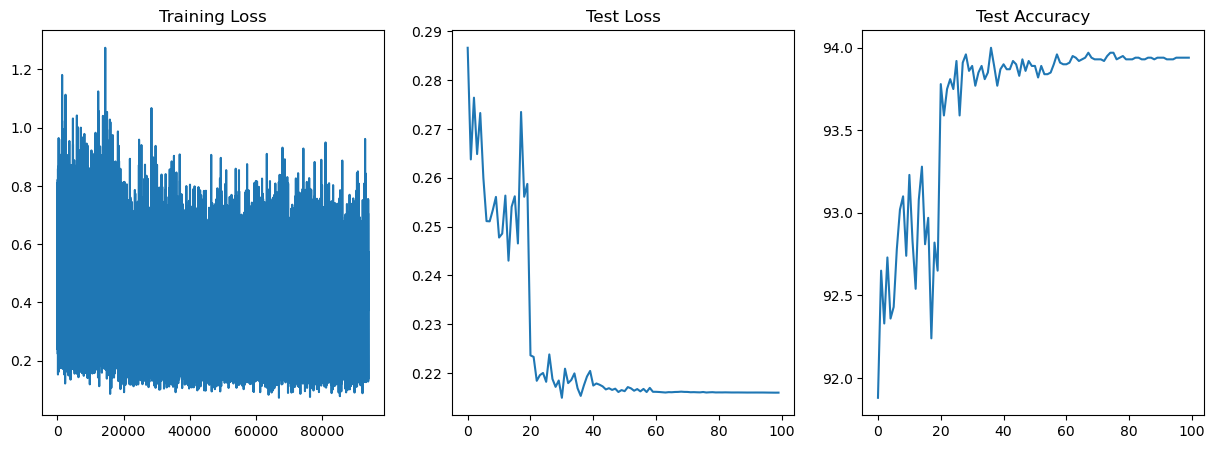

In [23]:
# Let's plot the training loss versus the number of iteration.
fig_height = 5
plt.figure(figsize=(3*fig_height, fig_height))

plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title("Training Loss")

plt.subplot(1, 3, 2)
plt.plot(test_loss)
plt.title("Test Loss")

plt.subplot(1, 3, 3)
plt.plot(test_accuracy)
plt.title("Test Accuracy")

In [24]:
# Reloading the best model
saved_acc = max(Saved_models)
if saved_acc > best_accuracy:
    print(f'Loading from Saved models, accuracy: {saved_acc:.2f}%')
    best_model_dict = Saved_models[max_acc]
else:
    print(f'Loading from last training session, accuracy: {best_accuracy:.2f}%')
    best_model_dict = best_model
    
model_mlp12.load_state_dict(best_model_dict)

Loading from last training session, accuracy: 94.00%


<All keys matched successfully>

# Test the Trained Model

Expected: 6. Predicted: 6.


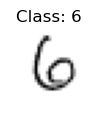

In [25]:
# Return the prediction
def predict(item):  # item: an item in the dataset
    model_mlp12.eval()
    # Extract features
    batch = [item]  # make a batch with single example
    tensor, target = collate_fn(batch)
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    target = target.to(device)
    output = model_mlp12(tensor)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch
    return pred


# Run a prediction
select_index = 100
item = Test_dataset[select_index]
pred = predict(item)
print(f"Expected: {item[1]}. Predicted: {pred}.")
showItem(item)

# Save Model and Test Dataset

The **test dataset** and the prediction by the trained model is saved as the following dictionary:
- label_dict: {label: index}
- dataset_schema: structure of dataset items
- dataset: list of items
    - item: (label, label_index, predicted_index, feature_length, feature_vector)


The **trained model** is saved as the following dictionary:
- accuracy: percent accuracy as float
- correct_count: no. of correct prediction as integer
- Hparam: model hyper parameters as dictionary
- state_dict: The nn.Model.state_dict() of the trained model

In [26]:
# Computing accuracy and building the dataset records for exporting
correct_count = 0
dataset = []
for data in tqdm(Test_dataset):
    pred = predict(data)
    feature, target = collate_fn([data])   # as batch with single item
    feature, target = feature[0], target[0]
    item = [data[1], target.item(), pred.item(), len(feature), feature.tolist()]
    if pred==data[1]: correct_count += 1
    dataset.append(item)

accuracy = (100.0 * correct_count) / len(Test_dataset)

print('dataset:', len(dataset), '  Test_dataset:', len(Test_dataset))
print('correct_count:', correct_count)
print(f'accuracy: {accuracy:.2f}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

dataset: 10000   Test_dataset: 10000
correct_count: 9400
accuracy: 94.00%


In [27]:
# Saving the Model with hyper-parameters and accuracy
save_path = './saved/trained_mlp12.pt'
model_dict = {
    'accuracy'     : accuracy,
    'correct_count': correct_count,
    'Hparam'       : Hparam,   # Hparam was defined while instantiating the model
    'state_dict'   : model_mlp12.state_dict()
}
torch.save(model_dict, save_path)
!ls -ltrh ./saved

total 68M
-rw-rw-r-- 1 makabir makabir 68M Jun 17 01:31 test_dataset.pt
-rw-rw-r-- 1 makabir makabir 40K Jun 17 01:34 trained_mlp12-93.37p.pt
-rw-rw-r-- 1 makabir makabir 40K Jun 17 02:30 trained_mlp12.pt


In [28]:
# Check the dataset records
item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]

print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

item: [7, 7, 7, 784]
feat_vec: <class 'list'> 784


In [29]:
# Build the dataset dictionary for exporting
label_dict = {label:label for label in Labels}
schema = "(label, label_index, predicted_index, feature_length, feature_vector)"
export_test = {
    'label_dict': label_dict,
    'dataset_schema': schema,
    'dataset': dataset
}

# Test exported dataset dictionary
keys = list(export_test.keys())
keys.remove('dataset')
for k in keys:
    print(k+':', export_test[k])

item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]
print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

label_dict: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
dataset_schema: (label, label_index, predicted_index, feature_length, feature_vector)
item: [7, 7, 7, 784]
feat_vec: <class 'list'> 784


In [30]:
# Save the dataset dictionary as PyTorch object
save_path = './saved/test_dataset.pt'
torch.save(export_test, save_path)
!ls -ltrh ./saved

total 68M
-rw-rw-r-- 1 makabir makabir 40K Jun 17 01:34 trained_mlp12-93.37p.pt
-rw-rw-r-- 1 makabir makabir 40K Jun 17 02:30 trained_mlp12.pt
-rw-rw-r-- 1 makabir makabir 68M Jun 17 02:30 test_dataset.pt


# Test prediction from Exported Dataset item

## Dataset related utilities

In [31]:
# Prints a dataset item
def print_dataitem(item):
    mstr = f"label: {item[0]}, label_index: {item[1]}, predicted_index: {item[2]}, feature_length: {item[3]},"
    mstr2 = f"feature_vector size: {len(item[4])}"
    print(mstr, mstr2)
    
    
# Given an item form the test_dataset, returns an example for predict() function
def make_example(data_item):
    feature = torch.tensor(data_item[4])
    return feature


# test prediction from dataset item
def predict_dataset(example, model=None):  # example: feature_vector
    model.eval()
    # Use the model to predict the label of the waveform
    feature = example.to(device)
    output = model(feature.unsqueeze(0))
    #print(output)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch
    return pred.item()

## Load and Test the Saved Dataset and Model

In [32]:
# Load the model
model_path = './saved/trained_mlp12.pt'
model_dict = torch.load(model_path)
print(model_dict.keys())
print(model_dict['Hparam'].keys())
print(f"     accuracy: {model_dict['accuracy']}%")
print(f"correct_count: {model_dict['correct_count']}")

loaded_hparam = model_dict['Hparam']
loaded_model = MLP12(loaded_hparam['input_size'], loaded_hparam['num_classes']).to(device)
loaded_model.load_state_dict(model_dict['state_dict'])
print('\n', loaded_model)

dict_keys(['accuracy', 'correct_count', 'Hparam', 'state_dict'])
dict_keys(['input_size', 'num_classes'])
     accuracy: 94.0%
correct_count: 9400

 MLP12(
  (fc1): Linear(in_features=784, out_features=12, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)


In [33]:
# Load dataset and predict using an item from it
ds_path = './saved/test_dataset.pt'
loaded_ds = torch.load(ds_path)
item = loaded_ds['dataset'][0]
example = make_example(item)
pred = predict_dataset(example, model=loaded_model)
print('pred:',pred)
print_dataitem(item)

pred: 7
label: 7, label_index: 7, predicted_index: 7, feature_length: 784, feature_vector size: 784


# Concluding Remarks

Now you can continue to the next notebook to implement the model with basic matrix-vector operations without using any PyTorch ML/DL related features. Be careful with the **dataset schema**.